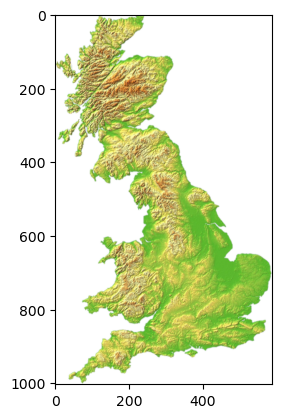

In [2]:
# load the base map from file
import matplotlib.pyplot as plt
import os

MY_PATH = r'C:\Users\bscho\Desktop\Packi Land V0'
os.chdir(MY_PATH)

img = plt.imread('GBmapsimple1.bmp')
imgplot = plt.imshow(img)
plt.show()

In [3]:
img[773][200:230]  # get a feel for the data

array([[177, 173,  88],
       [168, 164,  74],
       [195, 191, 106],
       [170, 165,  86],
       [165, 159,  77],
       [168, 161,  79],
       [140, 132,  51],
       [160, 151,  68],
       [155, 146,  62],
       [188, 178,  92],
       [225, 217, 130],
       [179, 170,  78],
       [181, 169,  74],
       [164, 152,  48],
       [201, 189,  82],
       [214, 203,  97],
       [174, 162,  64],
       [226, 216, 127],
       [248, 239, 158],
       [171, 160,  77],
       [181, 169,  81],
       [231, 212, 116],
       [212, 194,  88],
       [244, 235, 120],
       [252, 247, 133],
       [252, 247, 148],
       [251, 246, 166],
       [219, 213, 145],
       [188, 180, 117],
       [224, 207, 133]], dtype=uint8)

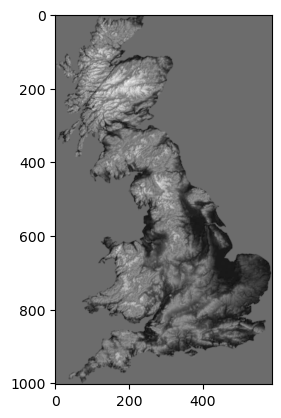

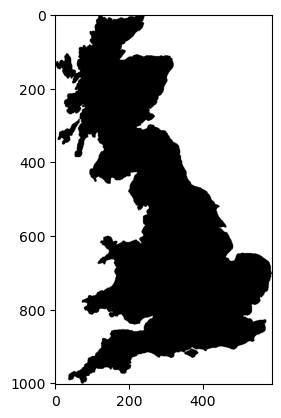

In [4]:
# transform to simple height from RGB
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def rgb2gray(rgb):
    #return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
    return np.dot(rgb[...,:3], [0.5, -0.6, 0.0])  # brown is higher up, green is lower

def rgb2mask(rgb):
    '''create a mask for the land to prevent movement into the sea'''
    filter_arr = []
    # go through each element in arr
    for row in rgb:
        filter_row = []
        for element in row:
            if element[0] == 255 and element[1] == 255 and element[2] == 255:
                filter_row.append(1)
            else:
                filter_row.append(0)
        filter_arr.append(filter_row)
    return filter_arr

#img = mpimg.imread('image.png')     
gray = rgb2gray(img)
gray *= (1.0/(gray.max() - gray.min()))
gray -= gray.min()
plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

mask = rgb2mask(img)
plt.imshow(mask, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

In [5]:
print(np.max(gray), np.min(gray))  # look at the data again
print('x, y:', len(gray[0]), len(gray))

0.9999999999999999 0.0
x, y: 587 1003


In [6]:
mask[800][400], mask[950][400]  # and again...

(0, 1)

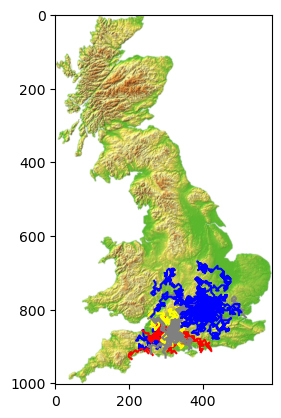

In [25]:
import random

def onestep(x, y, map, mask, factor=10):
    '''take one step on the map, considering the terrain'''
    nx, ny = x, y
    #if nx<0 or ny<0 or nx>len(map)-1 or ny>len(map[0])-1:
        #return -1, -1
    if mask[nx][ny] == 1:
        return -1, -1
    ctr = 0
    while mask[nx][ny] == 0 and ctr < 10:
        step = random.choice([(0,1), (1,1), (1,0), (1,-1), (0,-1), (-1,-1), (-1,0), (-1,1)])
        nx = max(min(len(map)-1, x + int(step[0] * factor * (1-map[nx][ny]))), 0)  # very simple terrain factor: the higher, the harder
        ny = max(min(len(map[0])-1, y + int(step[1] * factor * (1-map[nx][ny]))), 0)
        ctr += 1
    return nx, ny

# onestep(800, 400, gray, mask)

def walkpath(xstart, ystart, map, mask, nsteps=100):
    '''walk an entire path on the terrain'''
    path = []
    x, y = xstart, ystart
    n = 0
    while n < nsteps and x > 0 and y > 0:
        x, y = onestep(x, y, gray, mask)
        if x>0 and y>0:
            path.append((x, y))
        n += 1
    return path

#cpath = walkpath(800, 400, gray, mask)
#plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)

plt.imshow(img)

startpoint = (900, 400)
nseedpaths = 8
ngenerations = 5
nnextgenpaths = 3
endpoints = []
# start with a few seed paths
for i in range(nseedpaths):
    cpath = walkpath(startpoint[0], startpoint[1], gray, mask)
    if len(cpath) > 0:
        endpoints.append(cpath[-1])
    plt.plot([x[1] for x in cpath], [x[0] for x in cpath], 'red')

# for each seed path, create generations of branches
colors = ['blue', 'red', 'yellow', 'grey']
for gencounts in range(ngenerations):
    ep2 = []
    for p in endpoints:
        for i in range(nnextgenpaths):
            cpath = walkpath(p[0], p[1], gray, mask)
            if len(cpath) > 0:
                ep2.append(cpath[-1])
            plt.plot([x[1] for x in cpath], [x[0] for x in cpath], colors[gencounts % len(colors)])
    endpoints = [p for p in ep2]
    
plt.show()

In [26]:
len(endpoints), endpoints[:2]

(15, [(782, 426), (813, 379)])

In [36]:
# determine basic statistics of expansion
import math

def dist(p0, p1):
    return math.sqrt((p0[0]-p1[0])**2 + (p0[1]-p1[1])**2)

def averagedist(startpoint, endpoints):
    return sum([dist(startpoint, p) for p in endpoints]) / len(endpoints)

mean = averagedist(startpoint, endpoints)

stdev = math.sqrt(sum([(dist(item, startpoint) - mean)**2 for item in endpoints]) / (len(endpoints) - 1))

print(f"mean: {mean:.2f}, stdev: {stdev:.2f}")

mean: 128.66, stdev: 48.49
